In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [2]:
# Importing package for KMeans algorithm
from sklearn.cluster import KMeans

# Feature extraction using SIFT
# takes list of images as input
# returns array of sift descriptors as ddescribed in task 
def extract_features(data):
    
    features = np.zeros((0, 128))
    
    for i in range(len(data)):
        im = data[i]
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(im,None)
        features = np.vstack((features, des))
                
    return features

# Running k_means and getting clusters
# take features from function above
# return vocabulary
def cluster_features(features, k=200):
    
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(features)
    return kmeans.cluster_centers_

# print(f"FEATURES:\n{features}")
# print(f"CLUSTERS:\n{clusters}")

In [3]:
#input clusters and data that is just and array of images
def bag_of_words(clusters, data, idf=True):
    # gets bag of words for each image in data
    all_bags = []
    for i in range(len(data)):
        im = data[i] # [0]
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(im,None)
        #print(des)
        
        # get histogram of clusters / bag of words for one image
        bag_of_words = np.zeros(len(clusters))
        for d in des:
            distances = np.linalg.norm(clusters - d, axis=1)
            bag_of_words[np.argmin(distances)] += 1
        all_bags.append(bag_of_words)
    
    if idf:
        bags_array = np.array(all_bags)
        bags_array[bags_array != 0] = 1
        
        idf_w = np.log(bags_array.shape[1] / np.sum(bags_array, axis=0))
        #print(np.min(np.log(bags_array.shape[1] / np.sum(bags_array, axis=0))))
        #print(all_bags[0])
        all_bags = [bag * idf_w for bag in all_bags]        
        #print(all_bags[0])
            
        
    return all_bags

#bags = bag_of_words(clusters, train)

In [4]:
import pandas as pd
category_tables = []

def make_table():
    #file name, true category, training/test set, word histogram
    table = {"file_name" : [],
             "category" : [],
             "test-train" : [],
             "im" : [],
             "hist": []}
    
    #get categories
    dir_list = []
    for dirs in os.listdir("caltech-101/101_ObjectCategories/"):
        dir_list.append(os.path.join("caltech-101/101_ObjectCategories", dirs))
        
    random.Random(6).shuffle(dir_list)      
    random_categories = dir_list[:1] 

    
    #get images from each category
    for category in random_categories:
        # get files in each category
        for file in os.listdir(category):
            table["file_name"] = table.get("file_name", []) + [file]
            table["category"] = table.get("category", []) + [category.split("/")[-1]]
            im = cv2.imread(os.path.join(category, file))
            gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            table["im"] = table.get("im", []) + [gray]
            
    # shuffle data and split into train and test
    test_train = []
    
    if len(table.get("category")) % 2 == 0:
        half = int(len(table.get("category")) / 2)
        #test_train = ["test"] * half + ["train"] * half
        test_train = ["test", "train"] * half

    else:
        half = int(len(table.get("category")) / 2)
        test_train = ["test", "train"] * half + ["train"]

    #random.Random(5).shuffle(test_train)
    
    table["test-train"] = test_train
        
    return table
    
table = make_table()

train = []
test = []

for i in range(len(table["test-train"])):
    test_train = table["test-train"]
    im = table["im"]
    
    if test_train[i] == "test":
        test.append(im[i])
    elif test_train[i] == "train":
        train.append(im[i])
        
# Gather descriptors in training image data set
features = extract_features(train)
# get vocabulary
clusters = cluster_features(features, k=1000)

#create bags of words for each image
table["hist"] = bag_of_words(clusters, table["im"], idf=True)

In [5]:
'''
    Gennemløb alle kategorier
    For hver kategori
        skaf alle billeder og split dem i train og test set
        for hvert billede i directory
'''

# Importing packages
import pandas as pd
from sklearn.model_selection import train_test_split

# List of tables
category_tables = []

# Function for generating table
def gen_table(path):
    # Current table
    this_table = {
        "file_name":[],
        "category":[],
        "train-test":[],
        "im":[],
        "hist":[],
    }

    # Retrieve images
    images = os.listdir(path)
    #print(images)

    # Train-test division
    train, test = train_test_split(images, test_size=0.5, random_state=42)
    conv_train = [cv2.imread(os.path.join(path, file)) for file in train]
    conv_test = [cv2.imread(os.path.join(path, file)) for file in test]

    for file in os.listdir(path):
        # File name
        this_table["file_name"] = this_table.get("file_name", []) + [file]
        # Category
        this_table["category"] = this_table.get("category", []) + [path.split("/")[-1]]
        # Image
        im = cv2.imread(os.path.join(path, file))
        im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        this_table["im"] = this_table.get("im", []) + [im_gray]
        # train or test
        train_test = "train" if file in train else "test"
        this_table["train-test"] = this_table.get("train-test", []) + [train_test]
    
    features = extract_features(conv_train)
    clusters = cluster_features(features, k=1000)
    this_table["hist"] = bag_of_words(clusters, this_table["im"], idf=False)


    category_tables.append(this_table)

# Categories and categories paths
category_limit = 20
category_path = "caltech-101/101_ObjectCategories"
categories = os.listdir(f"{category_path}/")[:category_limit]
category_dir_list = [os.path.join(category_path, category) for category in categories]

# Looping category_dir_list + generating table
for category_dir in category_dir_list:
    gen_table(category_dir)


In [6]:
df_list = [pd.DataFrame(table) for table in category_tables]
merged_tables = pd.concat(df_list)
merged_tables[:40]

# tb = pd.DataFrame(category_tables[1])
# tb

,file_name,category,train-test,im,hist
0,image_0032.jpg,gerenuk,test,"[[171, 171, 171, 171, 171, 171, 171, 171, 172,...","[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, ..."
1,image_0026.jpg,gerenuk,train,"[[95, 113, 118, 162, 83, 78, 98, 101, 87, 82, ...","[0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
2,image_0027.jpg,gerenuk,train,"[[152, 188, 192, 130, 127, 156, 191, 180, 159,...","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ..."
3,image_0033.jpg,gerenuk,train,"[[51, 59, 73, 84, 84, 81, 85, 93, 88, 68, 67, ...","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, ..."
4,image_0019.jpg,gerenuk,test,"[[130, 116, 97, 93, 101, 98, 95, 105, 86, 78, ...","[2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, ..."
5,image_0025.jpg,gerenuk,test,"[[89, 123, 120, 94, 94, 100, 99, 104, 79, 87, ...","[2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 3.0, 2.0, 1.0, ..."
6,image_0031.jpg,gerenuk,train,"[[6, 6, 9, 9, 6, 6, 21, 41, 62, 78, 68, 40, 25...","[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, ..."
7,image_0030.jpg,gerenuk,train,"[[196, 186, 171, 158, 150, 149, 153, 156, 165,...","[2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 4.0, 0.0, 1.0, ..."
8,image_0024.jpg,gerenuk,test,"[[130, 147, 140, 115, 107, 109, 111, 114, 114,...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ..."
9,image_0018.jpg,gerenuk,test,"[[137, 149, 72, 68, 56, 67, 120, 131, 115, 82,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [7]:
def common_words(hist1, hist2):
    min = np.minimum(hist1, hist2)
    return -np.sum(min)

def euclidian(hist1, hist2):
    hist1 = hist1 / np.linalg.norm(hist1)
    hist2 = hist2 / np.linalg.norm(hist2)

    return np.linalg.norm(hist1 - hist2)

def bhattacharyya(hist1, hist2):
    hist1 = hist1 / np.linalg.norm(hist1)
    hist2 = hist2 / np.linalg.norm(hist2)
    
    return np.sum((hist1*hist2)**.5)

def retrieve(df,  measure, retrieve=0):
    retrieval_img = df.iloc[retrieve]
    print(retrieval_img)
    
    distances = []
    for index, row in df.iterrows():
        dist = measure(retrieval_img.loc["hist"], row.loc["hist"])
        distances.append((dist, index))
    
    distances = sorted(distances, key = lambda x:x[0])
    print(distances)
    
    indexes = [dist[1] for dist in distances]
    print(indexes)
    
    #return merged_tables.iloc[indexes]
    return merged_tables.iloc[indexes]
    

#results = retrieve(merged_tables, measure=euclidian, retrieve=0)
results = retrieve(merged_tables, measure=bhattacharyya, retrieve=0)
results.iloc[:40]

file_name                                        image_0032.jpg
category                                                gerenuk
train-test                                                 test
im            [[171, 171, 171, 171, 171, 171, 171, 171, 172,...
hist          [0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, ...
Name: 0, dtype: object
[(0.3433406044631724, 9), (0.4045679641271784, 6), (0.42890319430839247, 59), (0.5578058534781571, 7), (0.7732922463113872, 24), (0.7939672290029025, 19), (0.8963987251669164, 44), (0.919243345148488, 13), (0.921889787543086, 5), (1.0168948366372033, 40), (1.0679209919262929, 135), (1.0694795434118993, 11), (1.0806754984341305, 649), (1.0861031948887434, 30), (1.1255708044966442, 26), (1.177236622217229, 51), (1.1792714985477053, 230), (1.179925692290049, 33), (1.1806668145525157, 7), (1.1922966461867683, 741), (1.197905891833362, 36), (1.215744245637692, 772), (1.227578500141258, 504), (1.229622470329773, 25), (1.2629543453119667, 39), (1.266249227

,file_name,category,train-test,im,hist
9,image_0018.jpg,gerenuk,test,"[[137, 149, 72, 68, 56, 67, 120, 131, 115, 82,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
6,image_0031.jpg,gerenuk,train,"[[6, 6, 9, 9, 6, 6, 21, 41, 62, 78, 68, 40, 25...","[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, ..."
25,image_0087.jpg,hawksbill,test,"[[81, 78, 78, 81, 79, 71, 64, 63, 57, 61, 66, ...","[1.0, 1.0, 2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, ..."
7,image_0030.jpg,gerenuk,train,"[[196, 186, 171, 158, 150, 149, 153, 156, 165,...","[2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 4.0, 0.0, 1.0, ..."
24,image_0005.jpg,gerenuk,test,"[[101, 106, 107, 104, 103, 106, 107, 105, 100,...","[2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
19,image_0006.jpg,gerenuk,test,"[[94, 93, 92, 89, 83, 78, 81, 89, 89, 88, 87, ...","[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, ..."
10,image_0020.jpg,hawksbill,test,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
13,image_0009.jpg,gerenuk,test,"[[49, 66, 66, 152, 144, 139, 120, 106, 42, 47,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, ..."
5,image_0025.jpg,gerenuk,test,"[[89, 123, 120, 94, 94, 100, 99, 104, 79, 87, ...","[2.0, 1.0, 2.0, 1.0, 0.0, 0.0, 3.0, 2.0, 1.0, ..."
6,image_0031.jpg,hawksbill,train,"[[67, 65, 63, 64, 66, 67, 67, 66, 62, 63, 64, ...","[2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, ..."


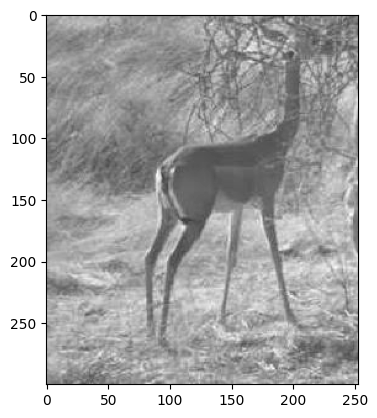

In [8]:
plt.imshow(results.iloc[18]["im"], cmap="gray", vmin=0, vmax=255)

In [9]:
# # clusters length
# '''
#     Filler code for testing
# '''
# images = os.listdir("caltech-101/101_ObjectCategories/hawksbill/")
# train, test = train_test_split(images, test_size=0.5, random_state=42)
# examples = [cv2.imread(os.path.join("caltech-101/101_ObjectCategories/hawksbill/", file)) for file in train]
# features = extract_features(examples)
# clusters = cluster_features(features, k=1000)

# #plot histograms
# plt.subplot(1, 2, 1)
# plt.bar(np.arange(0, len(clusters)), results.iloc[0]["hist"])
# plt.subplot(1, 2, 2)
# plt.bar(np.arange(0, len(clusters)), results.iloc[1]["hist"])

# Experiments

In [10]:
results_index = results.reset_index()

def experiment_train():
    mrr_train = 0
    top3_train = 0

    for i_merged, row_merged in merged_tables.iterrows():
        if row_merged["train-test"] == "train":
            for i_res, row_res in results_index.iterrows():
                #rank_i = 0
                if i_res == 0: continue                    
                if row_merged["category"] == row_res["category"]:
                    if i_res <= 3:
                        top3_train += 1
                    mrr_train += 1/i_res
                    break
    mrr_train /= len(results[results["train-test"] == "train"])
    percentage_top3_train = (top3_train / len(results[results["train-test"] == "train"])) * 100
    print(mrr_train, percentage_top3_train)
experiment_train()

results_index = results.reset_index()
def experiment_test():
    mrr_test = 0
    top3_test = 0

    for i_merged, row_merged in merged_tables.iterrows():
        if row_merged["train-test"] == "test":
            for i_res, row_res in results_index.iterrows():
                #rank_i = 0
                if i_res == 0: continue
                if row_merged["category"] == row_res["category"]:
                    if i_res <= 3:
                        top3_test += 1
                    mrr_test += 1/i_res
                    break
    mrr_test /= len(results[results["train-test"] == "test"])
    percentage_top3_test = (top3_test / len(results[results["train-test"] == "test"])) * 100

    print(mrr_test, percentage_top3_test)
experiment_test()

0.06271920035391955 7.346491228070176
0.05848400807554283 6.8158697863682605
